<a href="https://colab.research.google.com/github/gokmenkilic/ML-Intro/blob/gk%2Ftests/Astronomy_Galaxy_Classification_(CNN)_solution_T4_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Galaxy classification using convolutional neural networks

In this notebook, we attempt to classify galaxies according to their shape using CNN.


The data in this example is a subset of the [Galaxy10 dataset](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/). The images are categorized according to their shapes. We use a slimmed down dataset which contains 8 classes:

'Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral', 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge'.


The aim of this work is to train a neural network to classify the galaxy images.

In [1]:
# 1. Check CPU Model & Cores
print("--- CPU DETAILS ---")
!lscpu | grep 'Model name'
!lscpu | grep 'CPU(s):' | head -1
!lscpu | grep 'Thread(s) per core'

# 2. Check RAM (Total System Memory)
print("\n--- RAM DETAILS ---")
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print(f"Total RAM: {ram_gb:.2f} GB")

# 3. Check GPU (If enabled)
print("\n--- GPU DETAILS ---")
try:
  !nvidia-smi --query-gpu=name,memory.total --format=csv,noheader
except:
  print("No GPU detected (or nvidia-smi failed).")

# 4. Check Disk Space
print("\n--- DISK SPACE ---")
!df -h /content

--- CPU DETAILS ---
Model name:                              Intel(R) Xeon(R) CPU @ 2.20GHz
CPU(s):                                  2
Thread(s) per core:                      2

--- RAM DETAILS ---
Total RAM: 13.61 GB

--- GPU DETAILS ---
Tesla T4, 15360 MiB

--- DISK SPACE ---
Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   39G   74G  35% /


In [2]:
import sys
!{sys.executable} -m pip install tensorflow

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense, Dropout)
# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# helpers
import urllib.request
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pickle
from sklearn.model_selection import train_test_split
from os.path import join

# need some certainty in data processing
np.random.seed(1234)
tf.random.set_seed(1234)

Using TensorFlow v2.19.0


## Data Setup & Google Colab Environment

The dataset is hosted publicly by DiRAC on COSMA. **Please make sure you run the cell below to download the data.**

To access the data from COSMA, you need to:

1. Run the first cell;
2. It will create a folder called `sciml-workshop-data`.
3. It will download the necessary HDF5 files directly into that folder.
4. Run the second cell and wait until the data folder appears.

If everything works correctly, a new folder called `sciml-workshop-data` should appear in the file browser on the left. Depending on the network speed, this may take one or two minutes. Ignore the warning "You do not appear to have access to project ...". If you are running the notebook locally or you have already connected to the bucket, these cells will have no side effects.

In [3]:
# data setup configuration
data_path = 'sciml-workshop-data'
full_dir = os.path.join(data_path, 'Astronomy')
os.makedirs(full_dir, exist_ok=True)

base_url = "https://virgodb.cosma.dur.ac.uk/public/dc-kili1/sciml-workshop-data/Astronomy/"
files_to_download = ["Galaxy8.h5"]

In [4]:
for filename in files_to_download:
    path = os.path.join(full_dir, filename)

    if not os.path.exists(path):
        urllib.request.urlretrieve(base_url + filename, path)

---

# 1. Load the dataset

### Read raw data

The slimmed down dataset, which include the images with 8 labels, are stored in the h5 file `Galaxy8.h5`. We load this file using a `h5py` library.

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])
```
    
</p>
</details>

In [5]:
# load dataset
with h5py.File(join(data_path, 'Astronomy/Galaxy8.h5'), 'r') as F:
    x = np.array(F['images'])
    y = np.array(F['ans'])

In [6]:
# downsample the images - so that the model fits in memory.
x = x[:, ::2, ::2]

# normalise images
x = x / 255.0

# split train test
train_images, test_images, train_labels, test_labels = train_test_split(x, y, test_size=0.2, random_state=0)


# string labels
string_labels = ['Disturbed', 'Merging', 'Round Smooth', 'Barred Spiral',
                 'Unbarred Tight Spiral', 'Unbarred Loose Spiral', 'Edge-on without Bulge', 'Edge-on with Bulge']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0, :, :, 0].shape))
print("Number of channels: %s" % str(train_images.shape[-1]))


Number of training data: 6400
Number of test data: 1600
Image pixels: (64, 64)
Number of channels: 3


### We can randomly plot some images and their labels

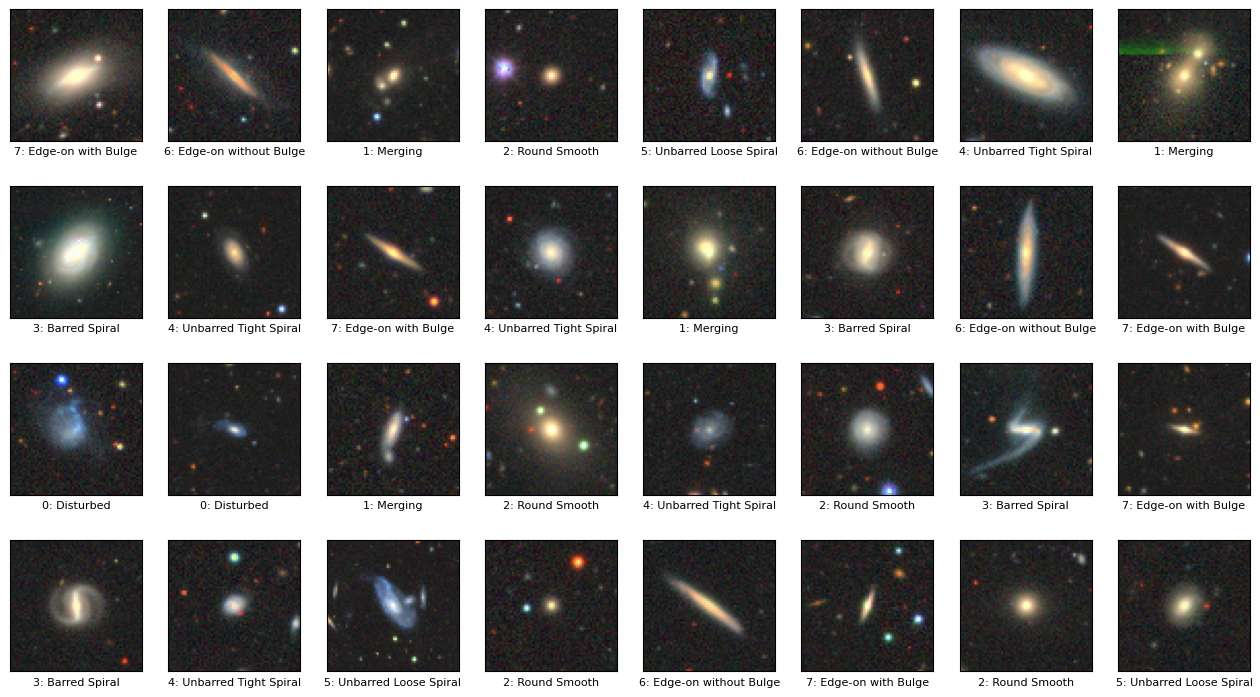

In [7]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image.squeeze(), cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=8)
    plt.title(label2, c=label2_color, fontsize=8, y=-0.33)
    plt.xticks([])
    plt.yticks([])

# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# 2. Build the network

In this case, we have 8 classes. Hence, the number of the outputs is 8. Then, we use 'SparseCategoricalCrossentropy' and will see 'accuracy' while training the model.



**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# build the network architecture
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()
```
    
</p>
</details>


In [8]:
# build the network architecture
model = Sequential()
model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='sigmoid'))

# print summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 16)     │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,872 (1.22 MB)

 Trainable params: 320,648 (1.22 MB)

 Non-trainable params: 224 (896.00 B)

### Compile and train the model

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                             validation_data=(test_images, test_labels))
```
    
</p>
</details>

In [9]:
# optimizer, loss, metrics
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# train the model
training_history = model.fit(train_images, train_labels, epochs=50, batch_size=32,
                             validation_data=(test_images, test_labels))

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.3114 - loss: 1.9833 - val_accuracy: 0.1875 - val_loss: 4.0125
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.4930 - loss: 1.3008 - val_accuracy: 0.1931 - val_loss: 3.3016
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5807 - loss: 1.1077 - val_accuracy: 0.5150 - val_loss: 1.2838
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6469 - loss: 0.9501 - val_accuracy: 0.5688 - val_loss: 1.1611
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7079 - loss: 0.7993 - val_accuracy: 0.5663 - val_loss: 1.3262
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7544 - loss: 0.6625 - val_accuracy: 0.5250 - val_loss: 1.4501
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7884 - loss: 0.5624 - val_accuracy: 0.5869 - val_loss: 1.4149
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8191 - loss: 0.4942 - val_accuracy: 

---

# 3. Analyse results

### Check training history

**Suggested Answer**

<details> <summary>Show / Hide</summary>
<p>
    
```python
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()
```
    
</p>
</details>

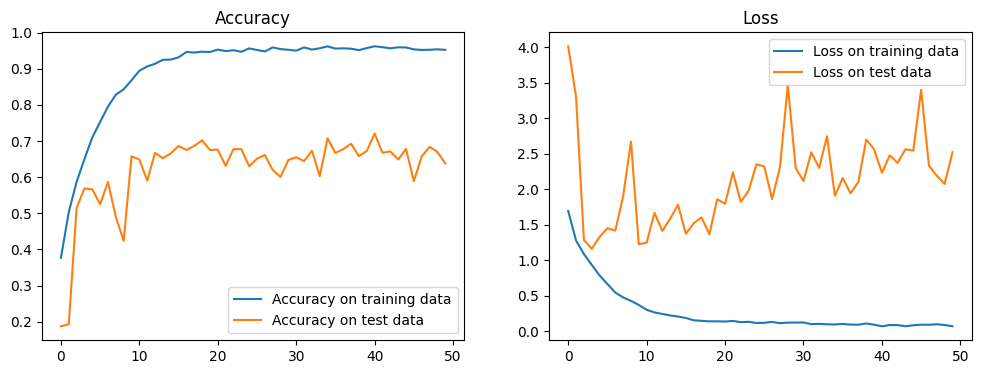

In [10]:
# plot accuracy
plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history.history[acc_str], label='Accuracy on training data')
plt.plot(training_history.history['val_' + acc_str], label='Accuracy on test data')
plt.legend()
plt.title("Accuracy")

# plot loss
plt.subplot(1, 2, 2)
plt.plot(training_history.history['loss'], label='Loss on training data')
plt.plot(training_history.history['val_loss'], label='Loss on test data')
plt.legend()
plt.title("Loss")
plt.show()

In [11]:
# use test images to predict
pred_lables = model.predict(test_images).argmax(axis=1)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Number of test data: 1600
Number of wrong predictions: 579


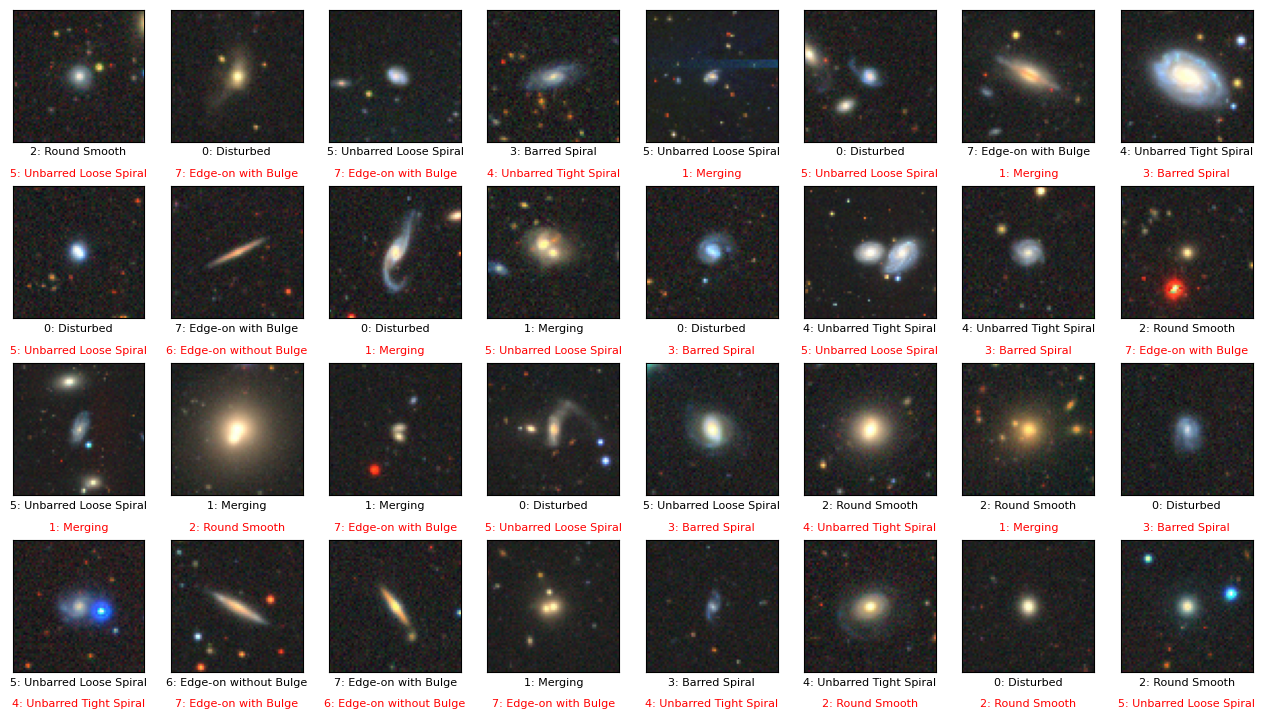

In [12]:
# get the indices of wrong predictions
id_wrong = np.where(pred_lables != test_labels)[0]
print("Number of test data: %d" % test_labels.size)
print("Number of wrong predictions: %d" % id_wrong.size)

# plot the wrong predictions
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(id_wrong, nrows * ncols)):
    label = "%d: %s" % (test_labels[idata], string_labels[test_labels[idata]])
    label2 = "%d: %s" % (pred_lables[idata], string_labels[pred_lables[idata]])
    subplot_image(test_images[idata], label, nrows, ncols, iplot, label2, 'r')
plt.show()

---

# 4. Exercises

* Classify a more complicated dataset, e.g., a randomly rotated galaxies as shown below. For the augmented dataset, compare the accuracy of a CNN and a fully connected DNN.  

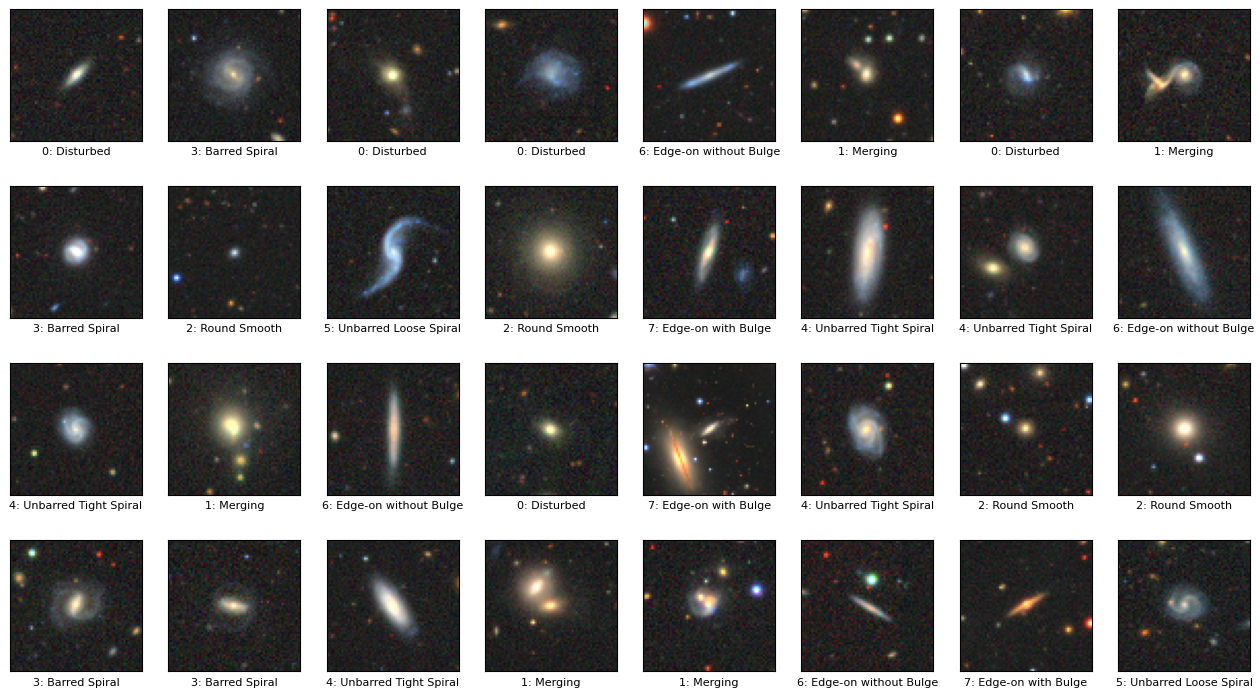

In [13]:
# rotate images randomly by k * 90 degrees
# train
train_images_rot = train_images.copy()
for i in np.arange(train_images.shape[0]):
    train_images_rot[i] = np.rot90(train_images[i], k=np.random.choice([0, 1, 2, 3]))

# test
test_images_rot = test_images.copy()
for i in np.arange(test_images.shape[0]):
    test_images_rot[i] = np.rot90(test_images[i], k=np.random.choice([0, 1, 2, 3]))

# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images_rot[idata], label, nrows, ncols, iplot)
plt.show()